# Step 1: Download a dataset and preview images


In [21]:
# !tar -xvf './cifar100.tar'

# Step 2: Custom Data Loading

In [22]:
import os
import time
import glob
import torch
import shutil
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

config = {
    "data_path":"./cifar100",
    "batch_size":128,
}

class mydataset(Dataset):
    def __init__(self, data_dir, flag, transform):
        super(mydataset,self).__init__()
        self.root       = data_dir
        self.label      = flag
        self.transform  = transform

        self.img_dir = os.path.join(self.root, self.label)
        self.img_names  = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

    def RGB2Gradient(self, img:torch.tensor):
        """
        Converts an RGB image tensor to its gradient magnitude using Sobel operator.
        The output is replicated to 3 channels to match the input dimensions of the other branch.
        """
        
        # Define Sobel kernels
        sobel_kernel_x = torch.tensor([[-1., 0., 1.], 
                                       [-2., 0., 2.], 
                                       [-1., 0., 1.]], dtype=torch.float32).reshape((1, 1, 3, 3))
        sobel_kernel_y = torch.tensor([[-1., -2., -1.], 
                                       [ 0.,  0.,  0.], 
                                       [ 1.,  2.,  1.]], dtype=torch.float32).reshape((1, 1, 3, 3))

        sobel_kernel_x = sobel_kernel_x.to(img.device)
        sobel_kernel_y = sobel_kernel_y.to(img.device)

        # Convert to grayscale: [3, H, W] -> Output [1, H, W]
        # gray_img = img[0, :, :] * 0.2989 + img[1, :, :] * 0.5870 + img[2, :, :] * 0.1140
        # gray_img = gray_img.unsqueeze(0)
        gray_img = transforms.Grayscale(num_output_channels=1)(img)

        # Add batch dimension [1, H, W] -> [1, 1, H, W]
        gray_img_batch = gray_img.unsqueeze(0) 

        # [YOU NEED TO FILL] Apply Sobel filters
        # Use F.conv2d, gray_img_batch, and the Sobel kernels (sobel_kernel_x, sobel_kernel_y) 
        # to calculate the gradients in the x and y directions.
        grad_x = F.conv2d(gray_img_batch, sobel_kernel_x, padding=1)
        grad_y = F.conv2d(gray_img_batch, sobel_kernel_y, padding=1)
        
        # [YOU NEED TO FILL] Calculate gradient magnitude ---
        # Calculate the magnitude (G = sqrt(Gx^2 + Gy^2)) from grad_x and grad_y.
        # The result should be stored in a variable named 'magnitude'.
        magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

        # Normalize magnitude
        mag_min = magnitude.min()
        mag_max = magnitude.max()
        epsilon = 1e-6 # Avoid division by zero
        normalized_magnitude = (magnitude - mag_min) / (mag_max - mag_min + epsilon)
        
        # Replicate to 3 channels [1, 1, H, W] -> [1, 3, H, W]
        normalized_magnitude_3channel = normalized_magnitude.repeat(1, 3, 1, 1)

        # Remove batch dimension [1, 3, H, W] -> [3, H, W]
        return normalized_magnitude_3channel.squeeze(0)

    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(os.path.join(img_name)).convert('RGB')
        img = self.transform(img)
        
        # Compute gradient magnitude image
        grad_img = self.RGB2Gradient(img)

        tag = 0
        for i in range(len(self.tags)):
            if self.tags[i] in img_name:
                tag = i
                break

        return img, grad_img, tag

    def __len__(self):
        return len(self.img_names)

# transform_train = transforms.Compose([
#          transforms.Resize([72, 72]), # 稍微放大，再随机裁剪
#          transforms.RandomResizedCrop(64, scale=(0.8, 1.0)), # 随机裁剪拉伸
#          transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
#          transforms.RandomRotation(degrees=15), # 随机旋转±15度
#         #  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1), # 颜色抖动
#          transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # 随机模糊
#          transforms.ToTensor()
#          ])
transform_train = transforms.Compose(
        [transforms.Resize([64, 64]),
         transforms.RandomHorizontalFlip(p=0.5), # 随机水平翻转
         transforms.RandomRotation(degrees=15), # 随机旋转±15度
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 颜色抖动
         transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.9, 1.1)), # 随机裁剪拉伸
         transforms.ToTensor()])
transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
      transforms.ToTensor()])

train_dataset = mydataset(data_dir=config['data_path'], flag= "train", transform=transform_train)
test_dataset  = mydataset(data_dir=config['data_path'], flag= "test", transform=transform_test)

# define data loader
train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'], shuffle=True, num_workers=0, pin_memory=True, drop_last=False)

# Step 3: Configure the Neural Network

In [23]:
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential as Seq

class CommonBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride):        # 普通Block简单完成两次卷积操作
        super(CommonBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = x                                            # 普通Block的shortcut为直连，不需要升维下采样

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)       # 完成一次卷积
        x = self.bn2(self.conv2(x))                             # 第二次卷积不加relu激活函数

        x += identity                                           # 两路相加
        return F.relu(x, inplace=True)                          # 添加激活函数输出

class SpecialBlock(nn.Module):                                  # 特殊Block完成两次卷积操作，以及一次升维下采样
    def __init__(self, in_channel, out_channel, stride):        # 注意这里的stride传入一个数组，shortcut和残差部分stride不同
        super(SpecialBlock, self).__init__()
        self.change_channel = nn.Sequential(                    # 负责升维下采样的卷积网络change_channel
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=stride[0], padding=0, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride[1], padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        identity = self.change_channel(x)                       # 调用change_channel对输入修改，为后面相加做变换准备

        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.bn2(self.conv2(x))                             # 完成残差部分的卷积

        x += identity
        return F.relu(x, inplace=True)                          # 输出卷积单元

class ConvNet(nn.Module):
    # 修改为单分支特征提取网络，可被复用为双分支网络的子模块
    def __init__(self):
        super(ConvNet, self).__init__()
        self.prepare = nn.Sequential(           # 预处理==》[batch, 64, 56, 56]
            nn.Conv2d(3, 64, 7, 2, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1)
        )
        self.layer1 = nn.Sequential(            # layer1有点特别，由于输入输出的channel均是64，故两个CommonBlock
            CommonBlock(64, 64, 1),
            CommonBlock(64, 64, 1)
        )
        self.layer2 = nn.Sequential(            # layer234类似，由于输入输出的channel不同，故一个SpecialBlock，一个CommonBlock
            SpecialBlock(64, 128, [2, 1]),
            CommonBlock(128, 128, 1)
        )
        self.layer3 = nn.Sequential(
            SpecialBlock(128, 256, [2, 1]),
            CommonBlock(256, 256, 1)
        )
        self.layer4 = nn.Sequential(
            SpecialBlock(256, 512, [2, 1]),
            CommonBlock(512, 512, 1)
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 全局平均池化
    def forward(self, x):
        x = self.prepare(x)         # 预处理

        x = self.layer1(x)          # 四个卷积单元
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)    # 全局平均池化
        x = torch.flatten(x, 1)    # 展平

        return x

# ------------------- 注意力融合模块 -------------------
class AttentionFusion(nn.Module):
    """
    自适应融合两个分支的特征（RGB & Gradient）
    使用通道注意力机制生成加权系数
    """
    def __init__(self, in_dim=512):
        super(AttentionFusion, self).__init__()
        self.fc1 = nn.Linear(in_dim * 2, in_dim // 8)
        self.fc2 = nn.Linear(in_dim // 8, 2)  # 输出两个权重（对应RGB和Gradient）

    def forward(self, f_rgb, f_grad):
        # 拼接两个分支的全局特征
        fused = torch.cat([f_rgb, f_grad], dim=1)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(fused))))
        w_rgb = w[:, 0].unsqueeze(1)
        w_grad = w[:, 1].unsqueeze(1)
        # 加权融合
        out = w_rgb * f_rgb + w_grad * f_grad
        return out

# ------------------- 双分支模型定义 -------------------
class DualBranchNet(nn.Module):
    def __init__(self, classes_num=100):
        super(DualBranchNet, self).__init__()
        self.rgb_net = ConvNet()
        self.grad_net = ConvNet()
        
        self.fusion = AttentionFusion(in_dim=512)
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, classes_num)
        )
        
    def forward(self, rgb, grad):
        rgb_feat = self.rgb_net(rgb)
        grad_feat = self.grad_net(grad)
        
        # fused = torch.cat([rgb_feat, grad_feat], dim=1)
        fused = self.fusion(rgb_feat, grad_feat)
        out = self.classifier(fused)
        return out
    

config = {
    "lr":1e-2,
    "momentum":0.9,
    "weight_decay":1e-4,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DualBranchNet(classes_num=100).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])
# optimizer = torch.optim.AdamW(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

# Step 4: Train the network and save model

In [24]:
import time

class AverageMeter(object):
    def __init__(self):
      self.reset()

    def reset(self):
      self.val   = 0
      self.avg   = 0
      self.sum   = 0
      self.count = 0

    def update(self, val, n=1):
      self.val   = val
      self.sum   += val * n
      self.count += n
      self.avg   = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def train(train_loader, net, optimizer, criterion, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    top1       = AverageMeter()

    LOSS = AverageMeter()

    net.train()

    end = time.time()
    for i, (rgb, grad, target) in enumerate(train_loader, start=1):
        data_time.update(time.time() - end)

        rgb = rgb.to(device)
        grad = grad.to(device)
        target = target.to(device)

        out = net(rgb, grad)

        loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        top1.update(prec1.item(), rgb.size(0))

        LOSS.update(loss.item(), rgb.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 1:
            log_str = ('Epoch[{0}]:[{1:03}/{2:03}] '
                       'Time:{batch_time.val:.4f} '
                       'Data:{data_time.val:.4f}  '
                       'loss:{loss.val:.4f}({loss.avg:.4f})  '
                       'prec@1:{top1.val:.2f}({top1.avg:.2f})  '.format(
                       epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time,
                       loss=LOSS,
                       top1=top1))
            print(log_str)

    return LOSS.avg

def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    for i, (rgb, grad, target) in enumerate(test_loader, start=1):
        rgb = rgb.to(device)
        grad = grad.to(device)
        target = target.to(device)

        with torch.no_grad():
            out = net(rgb, grad)
            loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), rgb.size(0))
        top1.update(prec1.item(), rgb.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

def save_checkpoint(state, is_best, save_root, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    # save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    # torch.save(state, save_path)
    if is_best:
        best_save_path = os.path.join(save_root, 'model_best.pth.tar')
        # shutil.copyfile(save_path, best_save_path)
        torch.save(state, best_save_path)

config = {
    "save_root":"./result",
    "epochs":30,
}

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"])

best_top1 = 0
test_top1 = 0
for epoch in range(1, config["epochs"]+1):
    # train one epoch
    epoch_start_time = time.time()
    train_loss = train(train_loader, net, optimizer, criterion, epoch)
    
    scheduler.step()
    print('current learning rate: {}'.format(optimizer.param_groups[0]['lr']))

    # evaluate on testing set
    test_top1 = test(test_loader, net, criterion)

    epoch_duration = time.time() - epoch_start_time
    print('Epoch time: {}s'.format(int(epoch_duration)))

    # save model
    is_best = False
    if test_top1 > best_top1:
        best_top1 = test_top1
        is_best = True
    print('Saving models......')
    save_checkpoint({
        'epoch': epoch,
        'net': net.state_dict(),
        'prec@1': test_top1,
    }, is_best, config["save_root"], epoch)

Epoch[1]:[001/391] Time:0.2868 Data:0.1942  loss:4.6015(4.6015)  prec@1:0.00(0.00)  
Epoch[1]:[051/391] Time:0.1992 Data:0.1832  loss:4.3572(4.4105)  prec@1:4.69(8.15)  
Epoch[1]:[101/391] Time:0.1865 Data:0.1757  loss:3.8936(4.2402)  prec@1:11.72(8.36)  
Epoch[1]:[151/391] Time:0.1858 Data:0.1753  loss:3.8354(4.1147)  prec@1:9.38(9.21)  
Epoch[1]:[201/391] Time:0.1926 Data:0.1811  loss:3.5891(4.0102)  prec@1:16.41(9.94)  
Epoch[1]:[251/391] Time:0.1895 Data:0.1780  loss:3.4390(3.9163)  prec@1:16.41(10.82)  
Epoch[1]:[301/391] Time:0.1885 Data:0.1774  loss:3.5922(3.8404)  prec@1:15.62(11.52)  
Epoch[1]:[351/391] Time:0.1930 Data:0.1819  loss:3.4585(3.7740)  prec@1:17.97(12.19)  
current learning rate: 0.009972609476841367
---------------------------------test classification result---------------------------------
Loss: 3.7876, Prec@1: 16.72%
Epoch time: 83s
Saving models......
Epoch[2]:[001/391] Time:0.1923 Data:0.1803  loss:3.3778(3.3778)  prec@1:16.41(16.41)  
Epoch[2]:[051/391] Time

# Step 5: Test on single image

In [25]:
img = Image.open("./cifar100/test/apple_9904.jpg")
img = transform_test(img)
grad = test_dataset.RGB2Gradient(img)
img = img.to(device).unsqueeze(0)
grad = grad.to(device).unsqueeze(0)
out = net(img, grad)
predicted_classes = torch.argmax(out, dim=1)
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

print(tags[predicted_classes[0]])

apple


# Step 6: Evaluate model accuracy

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DualBranchNet(classes_num=100).to(device)
checkpoint_path = "./result/model_best.pth.tar"
criterion = nn.CrossEntropyLoss().to(device)

class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]
    
def load_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['net'])
    print(f"Model load from {checkpoint_path} with accuracy: {checkpoint.get('prec@1', 'N/A')}")
    return model

def test(test_loader, net, criterion):
    losses = AverageMeter()
    top1   = AverageMeter()

    net.eval()

    for i, (rgb, grad, target) in enumerate(test_loader, start=1):
        rgb = rgb.to(device)
        grad = grad.to(device)
        target = target.to(device)

        with torch.no_grad():
            out = net(rgb, grad)
            loss = criterion(out, target)

        prec1 = accuracy(out, target) # prec1:list
        losses.update(loss.item(), rgb.size(0))
        top1.update(prec1.item(), rgb.size(0))

    f_l = [losses.avg, top1.avg]
    print('---------------------------------test classification result---------------------------------')
    print('Loss: {:.4f}, Prec@1: {:.2f}%'.format(*f_l))

    return top1.avg

model = load_model(model, checkpoint_path, device)

test_top1 = test(test_loader, model, criterion)

Model load from ./result/model_best.pth.tar with accuracy: 55.62
---------------------------------test classification result---------------------------------
Loss: 3.3591, Prec@1: 55.62%


# Step 7: T-SNE Visualization

## Use hooks in PyTorch to extract feature representations from the intermediate layers of the model for the test set "testloader", and visualize them using the T-SNE method. The specific requirements are as follows:
#### Visualize the features before and after the dual-branch feature fusion. If there are multiple fusions, you may choose specific layers for visualization.


Model loaded from ./result/model_best.pth.tar with accuracy: 55.62
---------------------------------test classification result---------------------------------
Loss: 3.3591, Prec@1: 55.62%


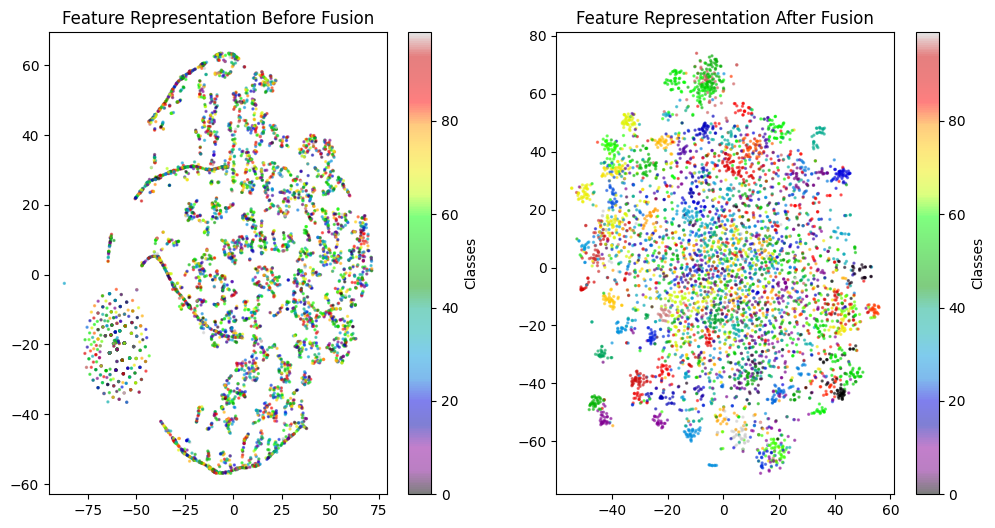

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
import os

features_before_fusion = []
features_after_fusion = []
all_targets = []

def load_model(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['net'])
    print(f"Model loaded from {checkpoint_path} with accuracy: {checkpoint.get('prec@1', 'N/A')}")
    return model

class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,1)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

def get_before_fusion_hook(module, input, output):
    """融合前的特征：RGB与Gradient拼接前的输出"""
    features_before_fusion.append(output[0].detach().cpu())

def get_after_fusion_hook(module, input, output):
    """融合后的特征：AttentionFusion输出"""
    features_after_fusion.append(output.detach().cpu())

def test_and_extract_features(test_loader, net, criterion, device):
    losses = AverageMeter()
    top1 = AverageMeter()

    net.eval()

    hook_handles = []
    hook_handles.append(net.fusion.register_forward_hook(get_after_fusion_hook))
    hook_handles.append(net.rgb_net.layer4.register_forward_hook(get_before_fusion_hook))

    global all_targets
    
    all_targets = []

    with torch.no_grad():
        for i, (rgb, grad, target) in enumerate(test_loader, start=1):
            rgb, grad, target = rgb.to(device), grad.to(device), target.to(device)

            out = net(rgb, grad)
            loss = criterion(out, target)

            prec1 = accuracy(out, target)
            losses.update(loss.item(), rgb.size(0))
            top1.update(prec1.item(), rgb.size(0))

            all_targets.append(target.detach().cpu())

    print('---------------------------------test classification result---------------------------------')
    print(f'Loss: {losses.avg:.4f}, Prec@1: {top1.avg:.2f}%')

    for handle in hook_handles:
        handle.remove()

    return top1.avg

def visualize_features(sample_limit=5000):
    features_before_fusion_concat = torch.cat([f.view(f.size(0), -1) for f in features_before_fusion], dim=0)
    features_after_fusion_concat = torch.cat([f.view(f.size(0), -1) for f in features_after_fusion], dim=0)
    all_targets_concat = torch.cat(all_targets, dim=0)
    
    
    min_len = min(
        features_before_fusion_concat.size(0),
        features_after_fusion_concat.size(0),
        all_targets_concat.size(0)
    )
    features_before_fusion_concat = features_before_fusion_concat[:min_len]
    features_after_fusion_concat = features_after_fusion_concat[:min_len]
    all_targets_concat = all_targets_concat[:min_len]
    
    if min_len > sample_limit:
        idx = torch.randperm(min_len)[:sample_limit]
        features_before_fusion_concat = features_before_fusion_concat[idx]
        features_after_fusion_concat = features_after_fusion_concat[idx]
        all_targets_concat = all_targets_concat[idx]
        

    features_before_fusion_np = features_before_fusion_concat.numpy()
    features_after_fusion_np = features_after_fusion_concat.numpy()
    all_targets_np = all_targets_concat.numpy()

    tsne = TSNE(n_components=2, random_state=0)
    features_before_fusion_2d = tsne.fit_transform(features_before_fusion_np)
    features_after_fusion_2d = tsne.fit_transform(features_after_fusion_np)

    norm = plt.Normalize(vmin=0, vmax=99)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(features_before_fusion_2d[:, 0], features_before_fusion_2d[:, 1], c=all_targets_np, cmap='nipy_spectral', norm=norm, alpha=0.5, s=2)
    plt.title("Feature Representation Before Fusion")
    plt.colorbar(label="Classes")
    
    plt.subplot(1, 2, 2)
    plt.scatter(features_after_fusion_2d[:, 0], features_after_fusion_2d[:, 1], c=all_targets_np, cmap='nipy_spectral', norm=norm, alpha=0.5, s=2)
    plt.title("Feature Representation After Fusion")
    plt.colorbar(label="Classes")

    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DualBranchNet(classes_num=100).to(device)
checkpoint_path = "./result/model_best.pth.tar"
model = load_model(model, checkpoint_path, device)

config = {
    "data_path":"./cifar100",
    "batch_size":128,
}

transform_test = transforms.Compose(
    [transforms.Resize([64, 64]),
      transforms.ToTensor()])

test_dataset = mydataset(data_dir=config['data_path'], flag="test", transform=transform_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'], shuffle=False, num_workers=0, pin_memory=True, drop_last=False
)

criterion = nn.CrossEntropyLoss().to(device)

test_top1 = test_and_extract_features(test_loader, model, criterion, device)

visualize_features()
